# Task 2 - Events 

This notebook will look into a dataset containing occurences of events such as opening and sending emails or page views, with the dataset containing information such as the type of event, when the event was created and the ID of the consumer. 

The aim of this notebook will be to perform some exploratory data analysis on the dataset and determine which events are more likely to occur together. 

### Import libraries

In [192]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Load and view dataset

In [205]:
# Load data
df = pd.read_csv('event.csv')

In [206]:
# View analysis of data
df.describe(include='all').T

,count,unique,top,freq
event_id,45447,45447,d22abb371f9c3f11346f4c7be25090e9,1
event_type,45447,7,email_open,24427
event_created_at,45447,31114,2021-09-14T08:01:34Z,899
event_consumer_id,45447,1854,b7730d37a71e86ea762a5367a9e88bf9,623


In [195]:
df.head()

,event_id,event_type,event_created_at,event_consumer_id
0,d22abb371f9c3f11346f4c7be25090e9,email_open,2020-12-01T07:51:31Z,01978065ceee79b338d479bd5eac41da
1,fa82669e074cf6238d5da6fefe4d0418,email_sent,2022-05-09T09:31:37Z,ff5a2159a4a246182a412fed5d68487d
2,7d6472f8a1c125fa284dd059a5a824e0,email_sent,2022-02-21T10:36:23Z,c65311834b7b58480f172acc37e37ae3
3,2cf9465cd75d91ab788fad79a236e110,email_sent,2022-01-19T10:43:02Z,94d1c1c392777ce9cc82945e169cc6d8
4,e0f39aca70247e8d555c09feda0d1aac,email_open,2020-10-19T10:25:27Z,de789b5f7bb18318419a8589ddac66de


We can see that we do not have any missing data and we have seven unique events. Therefore we can do some further analysis into these events: 

### Event Analysis

First we can look at the total counts of each event:

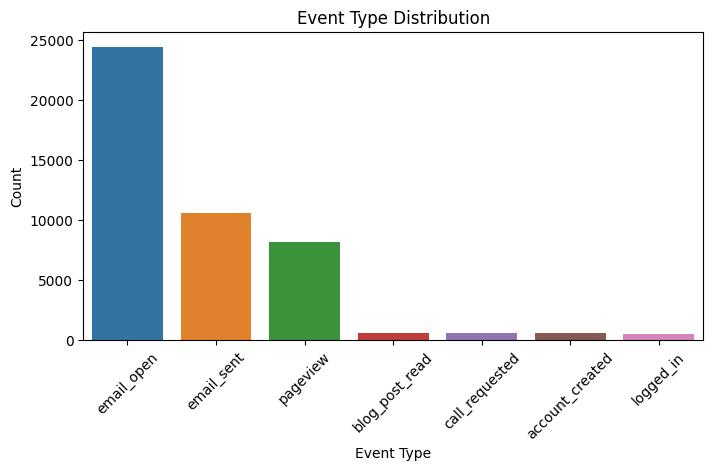

In [196]:
# Plotting histogram of event_type occurrences
plt.figure(figsize=(8, 4))
sns.countplot(data=df, x='event_type')
plt.title('Event Type Distribution')
plt.xlabel('Event Type')
plt.ylabel('Count')
plt.xticks(rotation=45);

Next we can add some extra features such as the hour, weekday and month of each event: 

In [198]:
# Convert to datetime
df['event_created_at'] = pd.to_datetime(df['event_created_at'])

# Create additional columns
df['day_of_week'] = df['event_created_at'].dt.day_of_week
df['hour'] = df['event_created_at'].dt.hour
df['month'] = df['event_created_at'].dt.month


We can plot the total occurences of events at each time interval: 

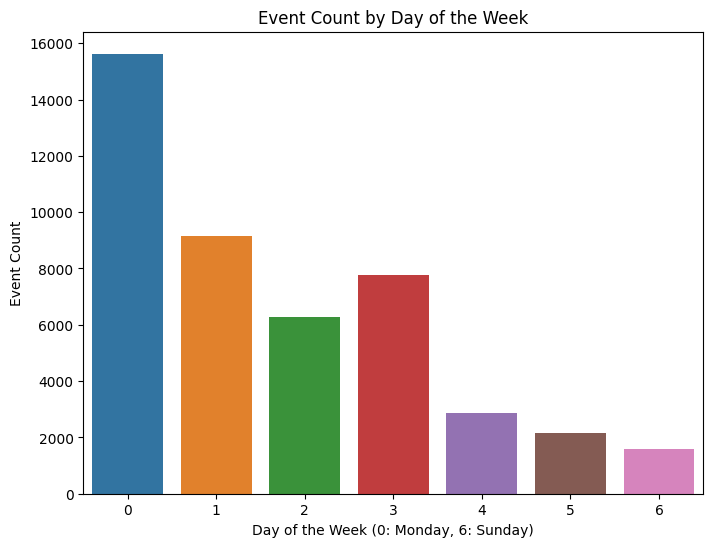

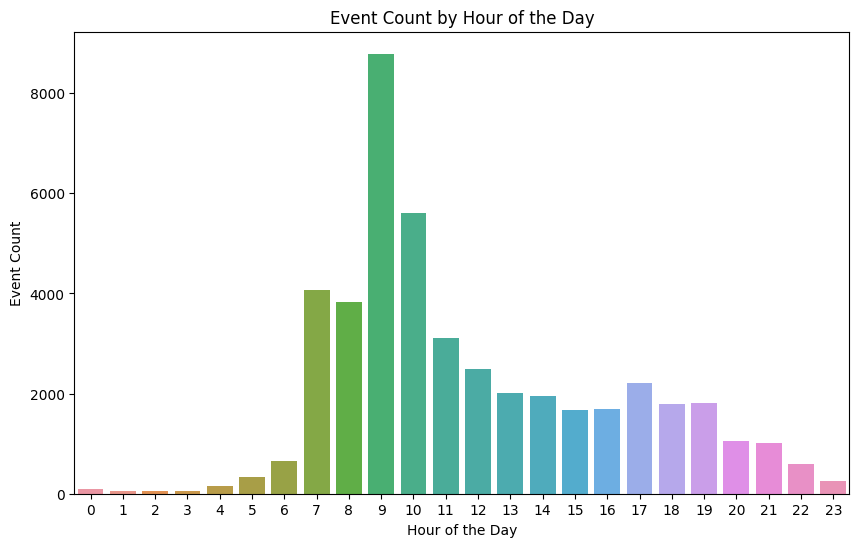

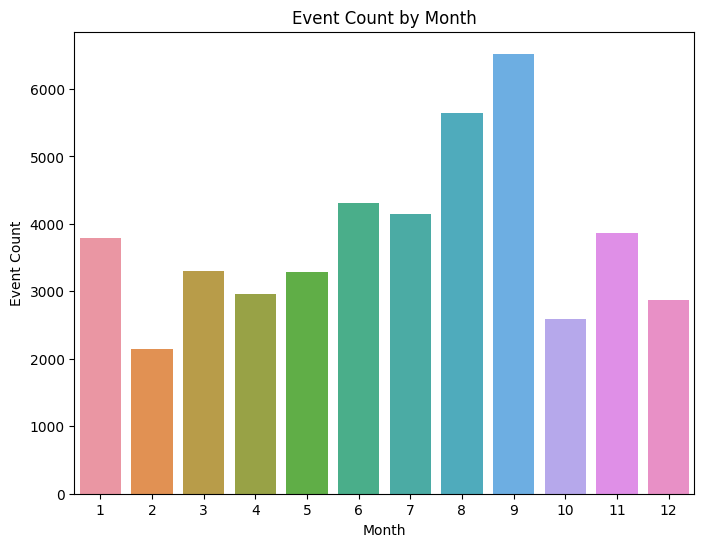

In [199]:
# Plotting event count by day of the week
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='day_of_week')
plt.title('Event Count by Day of the Week')
plt.xlabel('Day of the Week (0: Monday, 6: Sunday)')
plt.ylabel('Event Count')
plt.show()

# Plotting event count by hour of the day
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='hour')
plt.title('Event Count by Hour of the Day')
plt.xlabel('Hour of the Day')
plt.ylabel('Event Count')
plt.show()

# Plotting event count by month
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='month')
plt.title('Event Count by Month')
plt.xlabel('Month')
plt.ylabel('Event Count')
plt.show()

Next we can again plot these by time intervals, but split the bar charts by event type with each bar representing the percentage occurence of that event on each time interval out of the total occurence of that event:

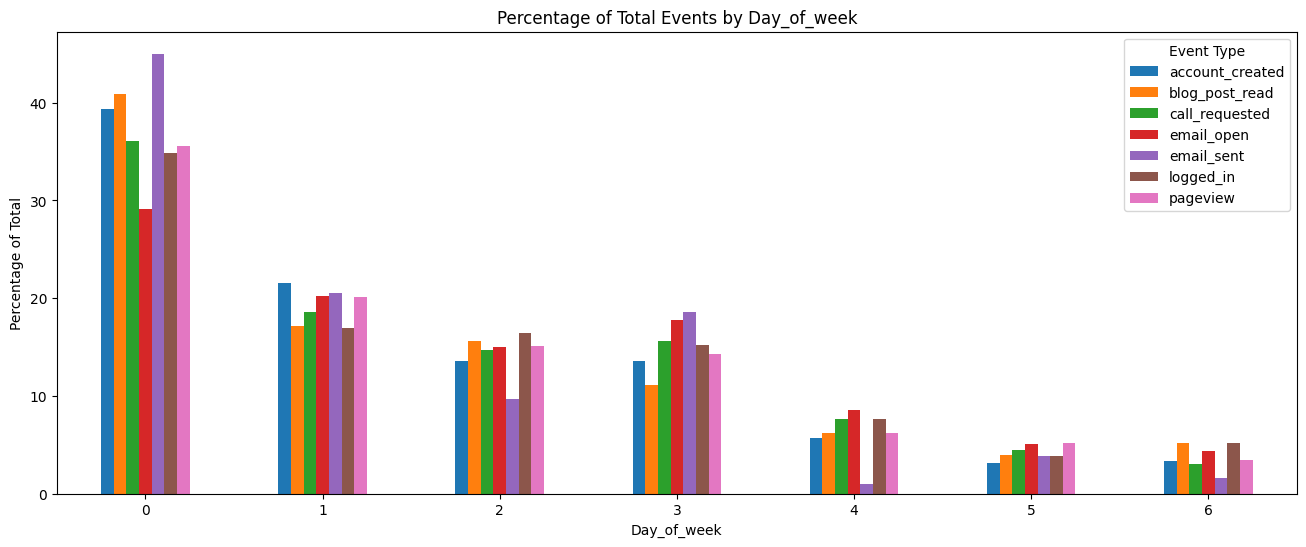

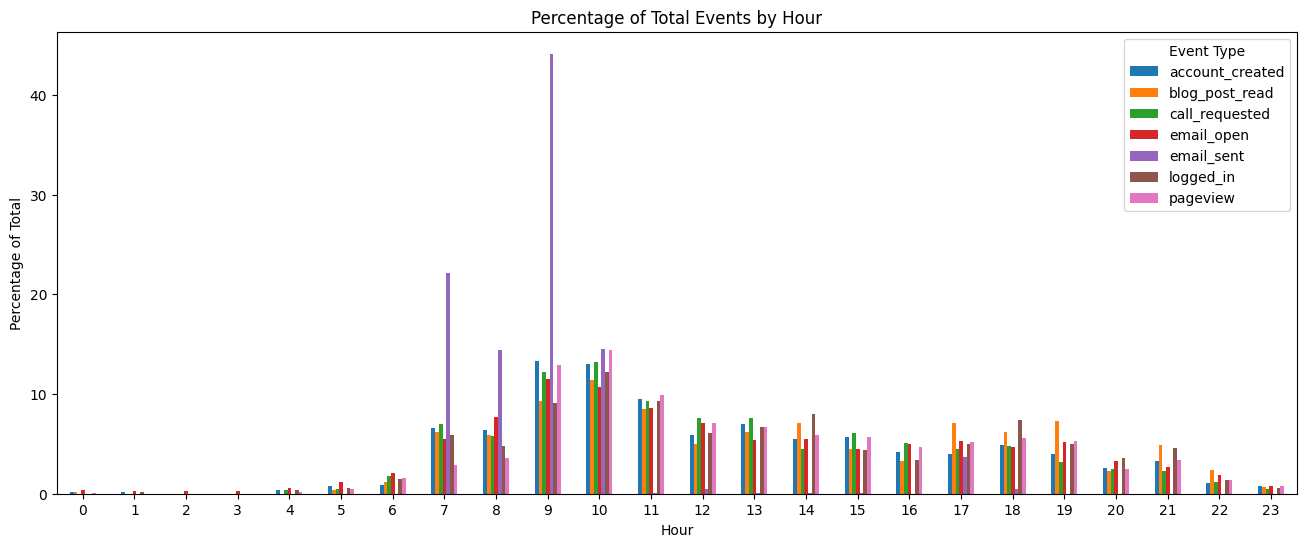

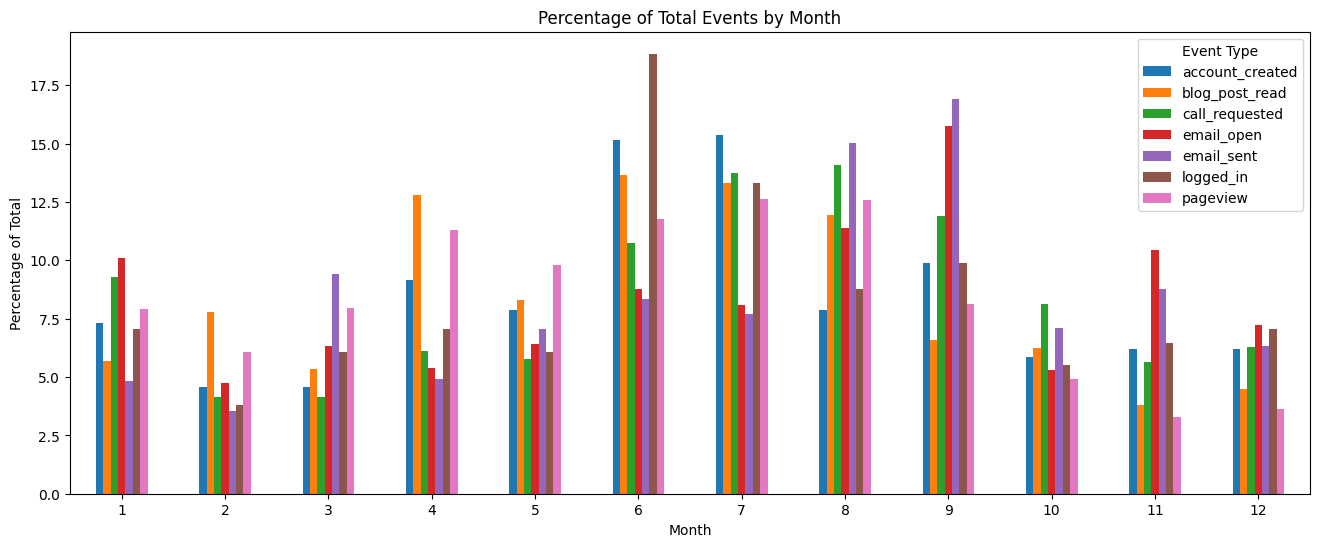

In [200]:
# Function to plot percentage of total events by a given column
def plot_percentage_by_column(column_name):
    # Grouping and aggregating the data
    grouped_df = df.groupby(['event_type', column_name]).size().reset_index(name='count')

    # Calculate the total count for each event type
    event_totals = grouped_df.groupby('event_type')['count'].sum()

    # Merge the event_totals with grouped_df to get the percentage
    grouped_df = grouped_df.merge(event_totals, on='event_type', suffixes=('', '_total'))
    grouped_df['percentage'] = grouped_df['count'] / grouped_df['count_total'] * 100

    # Pivot the DataFrame to get the column_name as columns and 'percentage' as values
    pivot_df = grouped_df.pivot(index=column_name, columns='event_type', values='percentage')

    # Plotting using Matplotlib
    pivot_df.plot(kind='bar', figsize=(16, 6))
    plt.xlabel(column_name.capitalize())
    plt.ylabel('Percentage of Total')
    plt.title(f'Percentage of Total Events by {column_name.capitalize()}')
    plt.xticks(rotation=0)
    plt.legend(title='Event Type')
    plt.show()

# Plot by day_of_week
plot_percentage_by_column('day_of_week')

# Plot by hour
plot_percentage_by_column('hour')

# Plot by month
plot_percentage_by_column('month')

### Find most popular previous and following events

We can aggregate our data by consumer and event_type to find the most popular event type that precedes and follows each event type for each customer:

In [201]:
# Sort our data by user and time
df.sort_values(['event_consumer_id', 'event_created_at'], inplace=True)

# First we define a mode function
def mode_func(x):
    mode_result = x.mode()
    return mode_result.iloc[0] if not mode_result.empty else None

# Add previous and next events as features
df['prev_event_type'] = df.groupby('event_consumer_id')['event_type'].shift(1)
df['next_event_type'] = df.groupby('event_consumer_id')['event_type'].shift(-1)

# Find most popular previous and following event for each customer
grouped_df = df.groupby(['event_consumer_id', 'event_type']).agg(
        most_common_prev_event = ('prev_event_type', mode_func),
        most_common_next_event = ('next_event_type', mode_func)
    )

grouped_df


most_common_prev_event   
event_consumer_id                event_type                          
000b28b987b38614b9f97b85c8fff460 email_sent                   None  \
004e404b8d7edbbdc3d317408a730ef2 email_open             email_open   
                                 email_sent             email_open   
                                 pageview                 pageview   
005d79771d8975e2de4523fd6525b5d4 email_sent             email_sent   
...                                                            ...   
ff959ab224776fabd72ab63e78cc05c7 email_open             email_open   
                                 email_sent                   None   
ffab3bb316926efb074fa71b39a3a126 email_open             email_sent   
                                 email_sent                   None   
ffdcb03c6f551b0a9cefca948158833e email_sent             email_sent   

                                            most_common_next_event  
event_consumer_id                event_type                         
000b28b987b38614b9f97b85c8fff460 email_sent                   None  
004e404b8d7edbbdc3d317408a730ef2 email_open             email_open  
                                 email_sent             email_open  
                                 pageview                 pageview  
005d79771d8975e2de4523fd6525b5d4 email_sent             email_sent  
...                                                            ...  
ff959ab224776fabd72ab63e78cc05c7 email_open             email_open  
                                 email_sent             email_open  
ffab3bb316926efb074fa71b39a3a126 email_open                   None  
                                 email_sent             email_open  
ffdcb03c6f551b0a9cefca948158833e email_sent             email_sent  

[5082 rows x 2 columns]

We can then aggregate our data again to show most common event prior to and after each event over all customers:

In [202]:
result_df = grouped_df.groupby('event_type').agg(
        most_common_prev_event = ('most_common_prev_event', mode_func),
        most_common_next_event = ('most_common_next_event', mode_func),
    )

result_df

,most_common_prev_event,most_common_next_event
event_type,,
account_created,pageview,pageview
blog_post_read,pageview,pageview
call_requested,pageview,pageview
email_open,email_open,email_open
email_sent,email_open,email_open
logged_in,pageview,pageview
pageview,pageview,pageview


### Plot a correlation matrix of events

We can create a pivot table showing the counts of each event_type for each consumer, then use this to plot a correlation matrix showing how strongly different 'event_type' categories are related to each other based on the count of 'event_id' occurrences for each 'event_consumer_id':

In [208]:
# Create a pivot table to count the occurrences of each event_type for each event_consumer_id
pivot_table = pd.pivot_table(df, index='event_consumer_id', columns='event_type', values='event_id', aggfunc='count', fill_value=0)

# Display the top 10 rows of the pivot table
pivot_table.head(10)

event_type,account_created,blog_post_read,call_requested,email_open,email_sent,logged_in,pageview
event_consumer_id,,,,,,,
000b28b987b38614b9f97b85c8fff460,0,0,0,0,1,0,0
004e404b8d7edbbdc3d317408a730ef2,0,0,0,36,13,0,4
005d79771d8975e2de4523fd6525b5d4,0,0,0,0,11,0,0
009de0b86087314c654887265693329f,0,0,0,0,10,0,0
00e7117db75ca1eb3f57f189e94dabc4,0,0,0,0,1,0,0
00f022a5711a60279971928c7cb8c647,1,0,2,85,5,2,28
01246fe6c536e1368bcd9ab50313a06d,2,10,1,7,4,6,88
01418ae55a3e0dd51631f2e7471df88e,0,0,0,1,1,0,0
014c4ad497a1b032182f21a0c82f02ac,0,0,2,14,5,0,10


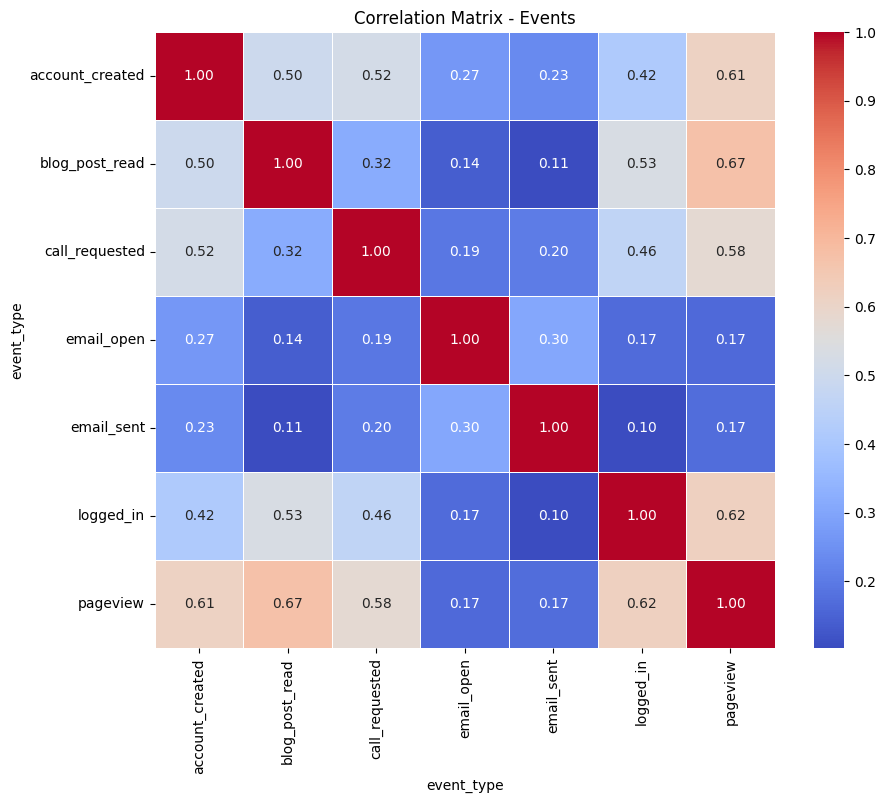

In [209]:
plt.figure(figsize=(10, 8))
# correlation matrix( relationships between events )
correlation_matrix = pivot_table.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix - Events')
plt.show()

We can see that read blog posts and page views are highly correlated with each other, and page views are generally highly correlated with all events except emails opened and emails sent.

## Conclusion

- Opening emails is by far the most common event type followed by sending emails and page views, with the rest of the events only taking up a small percentage.

- The most popular day for events to occur is Monday, with Friday only seeing very slightly more total events than the weekend

- The most popular time of day for events to occur is 9am followed by 10am and 7am. Very few events occur between 11pm and 7am. 

- The number of events generally increase gradually each month between February and September, before a steep drop off in October.

- Nearly half of all emails sent are sent on Monday and fewer emails are sent on Friday than on the weekends.

- Almost all emails are sent between 7am and 11am.

- Reading blog posts is generally the most popular event in the afternoon and event by proportion. 

- June and July are the most popular months for logging in and for accounts being created.

- Pageview is the most popular event prior to and after all other events except for opening and sending emails, where opening emails is the most popular priot and following event. 

- Similarly to above, when grouped by consumers, pageviews are highly correlated with all other events except for opening and sending emails, whereas emails opened and emails sent are most correlated with one another. 